# Scripted data collection

[Instamatic](https://github.com/instamatic-dev/instamatic) is a tool for automated electron diffraction data collection. It has interfaces for interfacing with the TEM (JEOL/TFS) and several cameras (ASI Timepix/Cheetah/TVIPS/Merlin).

This notebook shows some interactive examples of what basic data collection scripts may look like.

First, we must import and initialize the controller object, which defines the interface to the TEM and the camera. For this example, the microscope interaction is simulated.

In [1]:
from __future__ import annotations

from instamatic import controller
from instamatic.formats import write_tiff

ctrl = controller.initialize()

Config directory: C:\Users\vife5188\AppData\Roaming\instamatic\config
Microscope: simulate (server)
Connected to TEM server (localhost:8088)
Camera    : simulate (stream)

Mode: mag1
High tension: 200 kV
Current density: 96525.37 pA/cm2
GunShift(x=30508, y=5870)
GunTilt(x=23114, y=29671)
BeamShift(x=40370, y=43239)
BeamTilt(x=25352, y=15148)
ImageShift1(x=10985, y=54114)
ImageShift2(x=23225, y=17537)
DiffShift(x=3360, y=64377)
Stage(x=-54320.0, y=63143.0, z=-1420.0, a=-16.0, b=-1.0)
Magnification(value=25000, index=10)
DiffFocus(value=n/a)
Brightness(value=15034)
SpotSize(1)
Saved alignments: ('neutral.yaml',)


## Discrete rotation electron diffraction

This is an example script to collect electron diffraction data with discrete rotation steps with steps of 10° from -60 to 60°. The data are saved in a tiff file.

In [2]:
exposure = 0.5  # s
angles = range(-50, 51, 10)

for i, angle in enumerate(angles):
    ctrl.stage.set(a=angle)
    print(f"Frame {i} @ {ctrl.stage.a:.1f}°")
    img, h = ctrl.get_image(exposure=exposure)
    write_tiff(f"red_{i:04d}.tiff", img, header=h)


Frame 0 @ -50.0°
Frame 1 @ -40.0°
Frame 2 @ -30.0°
Frame 3 @ -20.0°
Frame 4 @ -10.0°
Frame 5 @ 0.0°
Frame 6 @ 10.0°
Frame 7 @ 20.0°
Frame 8 @ 30.0°
Frame 9 @ 40.0°
Frame 10 @ 50.0°


We can show the last image, but they are not very interesting, because they are simulated as noise :-)

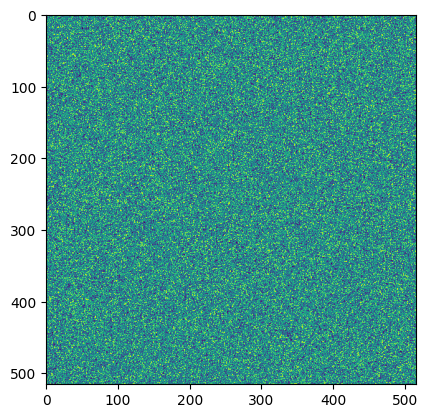

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(img)

## Continuous rotation electron diffraction

This is an example of what data collection would look like with a continuous rotation. The difference is that the target angle is set using `wait=False`. This means that the call is non-blocking, so that the script can continue. We will stop data collection once the angle has reached the target angle.

In [4]:
exposure = 0.5
start_angle =  50 # degrees
end_angle   = -50 # degrees

ctrl.stage.set(a=start_angle)
ctrl.stage.set(a=end_angle, wait=False)

buffer = []
i = 0

while ctrl.stage.a != end_angle:
    i += 1
    img, h = ctrl.get_image(exposure=exposure)
    buffer.append((img, h))
    print(f"Frame {i} @ {ctrl.stage.a:.1f}°")

for img, h in buffer:
    write_tiff(f"cred_{i:04d}.tiff", img, header=h)


Frame 1 @ 38.4°
Frame 2 @ 26.4°
Frame 3 @ 14.3°
Frame 4 @ 2.3°
Frame 5 @ -9.8°
Frame 6 @ -21.8°
Frame 7 @ -33.9°
Frame 8 @ -45.9°
Frame 9 @ -50.0°


## Serial electron diffraction

In a serial electron diffraction experiment, data are collected for a large number of crystals. The coordinates can be obtained from images taken at low magnification, but in this example a grid of coordinates will be created.

In [5]:
from instamatic.tools import prepare_grid_coordinates

nx, ny = 3, 3
stepsize = 1000 # nm -> µm

coords = prepare_grid_coordinates(nx=nx, ny=ny, stepsize=stepsize)
print(coords)

[[-1000. -1000.]
 [    0. -1000.]
 [ 1000. -1000.]
 [-1000.     0.]
 [    0.     0.]
 [ 1000.     0.]
 [-1000.  1000.]
 [    0.  1000.]
 [ 1000.  1000.]]


We then loop over every coordinate and collect a diffraction pattern. We can then defocus the diffraction pattern to obtain an image of the crystal in the primary beam.

In [6]:
exposure = 0.2  # s

ctrl.mode.set("diff")

for i, (x, y) in enumerate(coords):
    ctrl.stage.set(x=x, y=y)
    print(f"\nImage {i} @ Position: {ctrl.stage.xy}")

    img, h = ctrl.get_image(exposure=exposure)
    write_tiff(f"sed_diff_{i:04d}.tiff", img, header=h)

    ctrl.difffocus.defocus(offset=1500)

    img, h = ctrl.get_image(exposure=exposure)
    write_tiff(f"sed_image_{i:04d}.tiff", img, header=h)

    ctrl.difffocus.refocus()


Image 0 @ Position: (-1000.0, -1000.0)
Defocusing from 36687 to 38187
Refocusing to 36687

Image 1 @ Position: (0.0, -1000.0)
Defocusing from 36687 to 38187
Refocusing to 36687

Image 2 @ Position: (1000.0, -1000.0)
Defocusing from 36687 to 38187
Refocusing to 36687

Image 3 @ Position: (-1000.0, 0.0)
Defocusing from 36687 to 38187
Refocusing to 36687

Image 4 @ Position: (0.0, 0.0)
Defocusing from 36687 to 38187
Refocusing to 36687

Image 5 @ Position: (1000.0, 0.0)
Defocusing from 36687 to 38187
Refocusing to 36687

Image 6 @ Position: (-1000.0, 1000.0)
Defocusing from 36687 to 38187
Refocusing to 36687

Image 7 @ Position: (0.0, 1000.0)
Defocusing from 36687 to 38187
Refocusing to 36687

Image 8 @ Position: (1000.0, 1000.0)
Defocusing from 36687 to 38187
Refocusing to 36687


Alternatively, Instamatic can read `.nav` files exported from SerialEM and loop over the items with the acquire flag set. We make use of the `acquire_at_items` functionality to make `instamatic` handle the stage movement for us. Here is a simple example of how to acquire a diffraction pattern at every position and write it to a tiff file.

In [7]:
from pyserialem import read_nav_file

from instamatic.formats import write_tiff

exposure = 0.2

markers = read_nav_file("nav.nav", acquire_only=True)

ctrl.mode.set("diff")

def acquire(ctrl):
    img, h = ctrl.get_image(exposure=exposure)
    write_tiff(f"diff_{i:04d}.tiff", img, header=h)

ctrl.acquire_at_items(markers, acquire=acquire)

c:\Users\vife5188\Documents\instamatic\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Acquire[1]: acquire

Acquiring on 50 items.
Press <Ctrl-C> or ⬛ to interrupt.



100%|██████████| 50/50 [00:45<00:00,  1.10it/s]

Total time taken: 45 s for 50 items (0.91 s/item)

All done!


`acquire_at_items` offers a lot of options to run custom experiments, by specifying routines to run before, after or during the experiment.

In [8]:
def pre_acquire_1(ctrl):
    print("I run before the experiment")

def pre_acquire_2(ctrl):
    print("And so do I!")

def every_3(ctrl):
    print("I run every 3 cycles")

def every_5(ctrl):
    print("I run every 5 cycles")

def every_8(ctrl):
    print("I run every 8 cycles")

def acquire(ctrl):
    print("I'm actually collecting data...")
    img, h = ctrl.get_image(exposure=exposure)

def post_acquire(ctrl):
    print("I run after the experiment is finished (or interrupted)!")

every_n = {
    3: every_3,
    5: every_5,
    8: every_8
}

ctrl.acquire_at_items(markers,
                      pre_acquire=(pre_acquire_1, pre_acquire_2),
                      acquire=acquire,
                      post_acquire=post_acquire,
                      every_n=every_n)

Pre-acquire: pre_acquire_1, pre_acquire_2
Acquire[1]: acquire
Acquire[3]: every_3
Acquire[5]: every_5
Acquire[8]: every_8
Post-acquire: post_acquire

Acquiring on 50 items.
Press <Ctrl-C> or ⬛ to interrupt.

I run before the experiment
And so do I!


  0%|          | 0/50 [00:00<?, ?it/s]

I'm actually collecting data...


  2%|▏         | 1/50 [00:00<00:43,  1.12it/s]

I'm actually collecting data...


  4%|▍         | 2/50 [00:01<00:40,  1.19it/s]

I'm actually collecting data...


  6%|▌         | 3/50 [00:02<00:38,  1.21it/s]

I run every 3 cycles
I'm actually collecting data...


  8%|▊         | 4/50 [00:03<00:37,  1.22it/s]

I'm actually collecting data...
I run every 5 cycles


 10%|█         | 5/50 [00:04<00:36,  1.23it/s]

I'm actually collecting data...


 12%|█▏        | 6/50 [00:04<00:35,  1.23it/s]

I run every 3 cycles
I'm actually collecting data...


 14%|█▍        | 7/50 [00:05<00:34,  1.23it/s]

I'm actually collecting data...


 16%|█▌        | 8/50 [00:06<00:35,  1.19it/s]

I run every 8 cycles


 18%|█▊        | 9/50 [00:07<00:34,  1.20it/s]

I'm actually collecting data...
I run every 3 cycles
I'm actually collecting data...


 20%|██        | 10/50 [00:08<00:33,  1.21it/s]

I run every 5 cycles
I'm actually collecting data...


 22%|██▏       | 11/50 [00:09<00:32,  1.22it/s]

I'm actually collecting data...
I run every 3 cycles


 26%|██▌       | 13/50 [00:10<00:30,  1.22it/s]

I'm actually collecting data...
I'm actually collecting data...


 28%|██▊       | 14/50 [00:11<00:29,  1.22it/s]

I'm actually collecting data...


 30%|███       | 15/50 [00:12<00:28,  1.23it/s]

I run every 3 cycles
I run every 5 cycles
I'm actually collecting data...
I run every 8 cycles


 34%|███▍      | 17/50 [00:13<00:26,  1.23it/s]

I'm actually collecting data...
I'm actually collecting data...


 36%|███▌      | 18/50 [00:14<00:26,  1.23it/s]

I run every 3 cycles
I'm actually collecting data...


 38%|███▊      | 19/50 [00:15<00:25,  1.23it/s]

I'm actually collecting data...


 40%|████      | 20/50 [00:16<00:25,  1.18it/s]

I run every 5 cycles
I'm actually collecting data...


 42%|████▏     | 21/50 [00:17<00:24,  1.20it/s]

I run every 3 cycles
I'm actually collecting data...


 44%|████▍     | 22/50 [00:18<00:23,  1.21it/s]

I'm actually collecting data...


 46%|████▌     | 23/50 [00:18<00:22,  1.21it/s]

I'm actually collecting data...


 48%|████▊     | 24/50 [00:19<00:21,  1.22it/s]

I run every 3 cycles
I run every 8 cycles
I'm actually collecting data...


 50%|█████     | 25/50 [00:20<00:21,  1.18it/s]

I run every 5 cycles
I'm actually collecting data...


 52%|█████▏    | 26/50 [00:21<00:20,  1.15it/s]

I'm actually collecting data...


 54%|█████▍    | 27/50 [00:22<00:19,  1.17it/s]

I run every 3 cycles
I'm actually collecting data...


 58%|█████▊    | 29/50 [00:24<00:17,  1.20it/s]

I'm actually collecting data...
I'm actually collecting data...


 60%|██████    | 30/50 [00:24<00:16,  1.21it/s]

I run every 3 cycles
I run every 5 cycles
I'm actually collecting data...


 62%|██████▏   | 31/50 [00:25<00:15,  1.21it/s]

I'm actually collecting data...
I run every 8 cycles


 64%|██████▍   | 32/50 [00:26<00:14,  1.22it/s]

I'm actually collecting data...
I run every 3 cycles


 66%|██████▌   | 33/50 [00:27<00:13,  1.22it/s]

I'm actually collecting data...


 68%|██████▊   | 34/50 [00:28<00:13,  1.22it/s]

I'm actually collecting data...


 70%|███████   | 35/50 [00:28<00:12,  1.23it/s]

I run every 5 cycles
I'm actually collecting data...


 72%|███████▏  | 36/50 [00:29<00:11,  1.23it/s]

I run every 3 cycles
I'm actually collecting data...


 74%|███████▍  | 37/50 [00:30<00:10,  1.18it/s]

I'm actually collecting data...


 76%|███████▌  | 38/50 [00:31<00:10,  1.20it/s]

I'm actually collecting data...


 78%|███████▊  | 39/50 [00:32<00:09,  1.21it/s]

I run every 3 cycles
I'm actually collecting data...


 80%|████████  | 40/50 [00:33<00:08,  1.21it/s]

I run every 5 cycles
I run every 8 cycles
I'm actually collecting data...


 82%|████████▏ | 41/50 [00:33<00:07,  1.22it/s]

I'm actually collecting data...


 84%|████████▍ | 42/50 [00:34<00:06,  1.22it/s]

I run every 3 cycles
I'm actually collecting data...


 86%|████████▌ | 43/50 [00:35<00:05,  1.22it/s]

I'm actually collecting data...


 88%|████████▊ | 44/50 [00:36<00:04,  1.22it/s]

I'm actually collecting data...
I run every 3 cycles
I run every 5 cycles


 90%|█████████ | 45/50 [00:37<00:04,  1.23it/s]

I'm actually collecting data...


 92%|█████████▏| 46/50 [00:37<00:03,  1.22it/s]

I'm actually collecting data...


 94%|█████████▍| 47/50 [00:38<00:02,  1.23it/s]

I'm actually collecting data...


 96%|█████████▌| 48/50 [00:39<00:01,  1.23it/s]

I run every 3 cycles
I run every 8 cycles
I'm actually collecting data...


 98%|█████████▊| 49/50 [00:40<00:00,  1.23it/s]

I'm actually collecting data...


100%|██████████| 50/50 [00:41<00:00,  1.21it/s]

I run every 5 cycles
I run after the experiment is finished (or interrupted)!
Total time taken: 41 s for 50 items (0.82 s/item)

All done!
